# BÀI TOÁN DỰ ĐOÁN CHỨNG KHOÁN VỚI LSTMs


In [ ]:
# Description: This program uses Long Short Term Memory to predict the closing stock price , AAPL
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' \ --port=8080 --no-browser

# Import package
1.   Dash : Xây dựng trang web
2.   Keras: Xây dựng model sử dụng LSTM để train và test data
3.   Pandas_datareader, yfinance : Lấy dữ liệu về stock 
4.   Sklearn : Sử dụng Minmaxscaler để scale data về giữa 0 và 1
5.   Matplotlib.pyplot : Dùng để vẽ các đồ thị thể hiện dữ liệu



In [ ]:
#Import package
import math
import numpy as np
import dash
import pandas as pd
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import os
import requests
import yfinance as yf
import re
import tensorflow as tf
import copy
import plotly.tools as tls
import talib as tb
import keras

from flask import send_from_directory
from dash.exceptions import PreventUpdate
from dash.dependencies import Input, Output,State
from pandas_datareader import data as datard
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from keras.models import Sequential,load_model , Model
from keras.layers import Dense,LSTM , Dropout , Input as InputKL, Activation, concatenate , GRU ,Conv2D , Conv1D , MaxPooling1D, Flatten , MaxPooling2D
from yahoo_fin import stock_info as si
from plotly.subplots import make_subplots

<h2> Lấy giá trị cổ phiếu AAPL từ 24-12-2012 đến 24-12-2021 </h2>

In [ ]:
def get_stock_dataframe(ticker , startDate , endDate):
  #Get the stock
  df = datard.DataReader(ticker, 'stooq', startDate, endDate)
  #Reverse the data frame
  df = df.iloc[::-1]
  return df

startDate = pd.to_datetime('2012-12-24')
endDate = pd.to_datetime('2021-12-24')
df = get_stock_dataframe('AAPL' , startDate , endDate)


Writing code.py


In [ ]:
#Get stock symbol for search pannel in dash web
stock_frame_array = []
startDate = pd.to_datetime('2012-12-24')
endDate = pd.to_datetime('2021-12-24')

df2 = pd.DataFrame( si.tickers_dow())
stock_symbols = df2.values
stock_symbols = stock_symbols.reshape(stock_symbols.shape[0] , )

for i in range(len(stock_symbols) - 20):
  tmp_df = get_stock_dataframe(stock_symbols[i] , startDate , endDate)
  stock_frame_array.append(tmp_df)


In [ ]:
df.describe()

,Open,High,Low,Close,Volume
count,2267.000000,2267.000000,2267.000000,2267.000000,2.267000e+03
mean,50.157004,50.687993,49.645428,50.189978,1.951934e+08
std,39.703933,40.182650,39.240773,39.740966,1.488319e+08
min,12.054000,12.416000,11.966000,12.134000,4.099995e+07
25%,23.453500,23.672500,23.242000,23.537000,1.011901e+08
50%,35.735000,36.119000,35.406000,35.677000,1.445298e+08
75%,55.173500,55.515500,54.693000,55.029500,2.374365e+08
max,181.115000,182.130000,175.530000,179.450000,1.688039e+09


In [ ]:
tech_idx_1 = copy.deepcopy(df)
tech_idx_2 = copy.deepcopy(df)

<h2>* Import Indicator
</h2>


In [ ]:
#Moving Averages are used to smooth the data in an array to help eliminate noise and identify trends
#Each output value is the average of the previous n values
#Rolling window calculations (we take a window size of k (k consecutive values) at a time and perform some desired mathematical operation on it)
def MA(ticket_df , periods , name):
  ticket_df[name] = ticket_df['Close'].rolling(window = periods).mean()
  return ticket_df

#Exponential Moving Average is a staple of technical analysis and a cumulative calculation
#Past values have a diminishing contribution to the average, while more recent values have a greater contribution.
#Number of day = 20 default
def EMA(ticker_df , periods):
  k = 2 / (periods + 1)
  ticker_df.loc[ticker_df.index[0], 'EMA'] = ticker_df.loc[ticker_df.index[0], 'Close']
  ticker_df_index = ticker_df.index
  for index in range(len(ticker_df_index) - 1):
    ticker_df.loc[ticker_df_index[index+1], 'EMA'] = k * ticker_df.loc[ticker_df_index[index+1] , 'Close'] + (1-k) * ticker_df.loc[ticker_df_index[index] , 'EMA']
  return ticker_df


def RSI(ticker_df, periods = 14, ema = True):
    close_delta = ticker_df['Close'].diff()
    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    ticker_df['RSI'] = rsi
    return ticker_df



#The MACD signals trend changes and indicates the start of the new trend direction. 
#High values indicate overbought conditions, low values indicate oversold conditions.

def MACD(ticker_df):
  k1 = 2 / (12+1)
  k2 = 2 / (26+1)
  ticker_df.loc[ticker_df.index[0], 'EMA_1'] = ticker_df.loc[ticker_df.index[0], 'Close']
  ticker_df.loc[ticker_df.index[0], 'EMA_2'] = ticker_df.loc[ticker_df.index[0], 'Close']
  ticker_df_index = ticker_df.index
  for index in range(len(ticker_df_index) - 1):
    ticker_df.loc[ticker_df_index[index+1], 'EMA_1'] = k1 * ticker_df.loc[ticker_df_index[index+1] , 'Close'] + (1-k1) * ticker_df.loc[ticker_df_index[index] , 'EMA_1']
    ticker_df.loc[ticker_df_index[index+1], 'EMA_2'] = k2 * ticker_df.loc[ticker_df_index[index+1] , 'Close'] + (1-k2) * ticker_df.loc[ticker_df_index[index] , 'EMA_2']
  
  ticker_df['MACD'] = ticker_df['EMA_1'] - ticker_df['EMA_2']
  ticker_df = ticker_df.drop(['EMA_1' , 'EMA_2'] , axis = 1)

  return ticker_df


#The Stochastic Oscillator measures where the close is in relation to the recent trading range. 
#The values range from zero to 100. %D values over 75 indicate an overbought condition; values under 25 indicate an oversold condition
def caculate_k_so(ticker_df):
  close = ticker_df['Close']
  high = ticker_df['High'].rolling(window = 10).max()
  low = ticker_df['Low'].rolling(window = 10).min()
  ticker_df['stok'] = (close - low) / (high - low) * 100
  return ticker_df
  
def caculate_d_so(ticker_df):
  ticker_df['stod'] = ticker_df['stok'].rolling(window = 10).mean()
  return ticker_df

def stochastic_oscillator(ticker_df):
  ticker_df = caculate_k_so(ticker_df)
  ticker_df = caculate_d_so(ticker_df)
  return ticker_df


#The A/D line helps to show how supply and demand factors are influencing price. 
def accumalation_distribution(ticker_df):
  ##ticker_df is ordered by date with oldest date having index = 0
  values = pd.Series(index = ticker_df.index)
  first_idx = ticker_df.index.values[0]
  ticker_df_index = ticker_df.index.values
  for index in range(len(ticker_df_index)):
    today = ticker_df.loc[ticker_df_index[index]]
    close , high , low , volumne = today['Close'] ,  today['High'] , today['Low'] , today['Volume']
    #MFM (Money Flow Multiplier)
    MFM = ( (close - low) - (high - close) ) / (high - low)    
    values[ticker_df_index[index]] = values[ticker_df_index[index - 1]] + MFM * volumne if ticker_df_index[index] != first_idx else 0
    
  ticker_df['A/D'] = values
  ticker_df = ticker_df.iloc[::-1]
  return ticker_df

##
def BBANDS(ticker_df):
  ticker_df['TP'] = (ticker_df['High'] + ticker_df['Low'] + ticker_df['Close'] ) / 3
  ticker_df['MidBand_BB'] = ticker_df['TP'].rolling(window = 20).mean()
  ticker_df['Std'] = ticker_df['TP'].rolling(window = 20).std()
 
  ticker_df['UpperBand_BB'] = ticker_df['MidBand_BB'] + (ticker_df['Std'] * 2)
  ticker_df['LowerBand_BB'] = ticker_df['MidBand_BB'] - (ticker_df['Std'] * 2)

  ticker_df = ticker_df.drop(['Std' , 'TP'] , axis = 1)
  return ticker_df

def OBV(ticker_df):
  ticker_df_index = ticker_df.index
  for index in range(len(ticker_df_index) - 1):
    ticker_df.loc[ticker_df_index[index+1], 'OBV'] = abs(ticker_df.loc[ticker_df_index[index+1], 'Volume'] - ticker_df.loc[ticker_df_index[index], 'Volume'])
  return ticker_df

def ROC(ticker_df):
  ticker_df['ROC'] = ((ticker_df['Close'] - ticker_df['Close'].shift(12)) / ticker_df['Close'].shift(12)) * 100
  ticker_df['ROC'] = ticker_df['ROC'].fillna(0)
  return ticker_df

def Momentumn(ticker_df):
  ticker_df['Momentumn'] = ticker_df['Close'] - ticker_df['Close'].shift(4)
  ticker_df['Momentumn'] = ticker_df['Momentumn'].fillna(0)
  return ticker_df

<h2>Import Indicator Using Talib</h2>
<h6>Talib is widely used by trading software developers requiring to perform technical analysis of financial market data </h6>

In [ ]:
def technical_indicators_df(daily_data_df):
        """
        Assemble a dataframe of technical indicator series for a single stock
        """
        o = daily_data_df['Open'].values
        c = daily_data_df['Close'].values
        h = daily_data_df['High'].values
        l = daily_data_df['Low'].values
        v = daily_data_df['Volume'].astype(float).values
        # define the technical analysis matrix
        # Most data series are normalized by their series' mean
        ta = daily_data_df
        ta['MA3'] = tb.MA(c, timeperiod=3) 
        ta['MA10'] = tb.MA(c, timeperiod=10) 
        ta['MA20'] = tb.MA(c, timeperiod=20)
        ta['MA30'] = tb.MA(c, timeperiod=20) 
        ta['MA50'] = tb.MA(c, timeperiod=50) 
        ta['MA100'] = tb.MA(c, timeperiod=100) 
        ta['MA200'] = tb.MA(c, timeperiod=200) 
        # ta['MA5'] = tb.MA(v, timeperiod=5) 
        # ta['MA10'] = tb.MA(v, timeperiod=10) 
        # ta['MA20'] = tb.MA(v, timeperiod=20) 
        ta['ADX'] = tb.ADX(h, l, c, timeperiod=14) 
        ta['ADXR'] = tb.ADXR(h, l, c, timeperiod=14) 
        ta['MACD'] = tb.MACD(c, fastperiod=12, slowperiod=26, signalperiod=9)[0] 
        ta['MACDSignal'] = tb.MACD(c, fastperiod=12, slowperiod=26, signalperiod=9)[1] 
        ta['RSI'] = tb.RSI(c, timeperiod=14) 
        ta['OBV'] = tb.OBV(c , v)
        ta['OBV_EMA'] = ta['OBV'].ewm(com = 20).mean()
        ta['SMA'] = tb.SMA(c , timeperiod = 20)
        ta['EMA'] = tb.EMA(c , timeperiod = 20)
        ta['BBANDS_U'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[0] 
        ta['BBANDS_M'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1] 
        ta['BBANDS_L'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[2] 
        ta['AD'] = tb.AD(h, l, c, v) 
        ta['ATR'] = tb.ATR(h, l, c, timeperiod=14) 
        ta['HT_DC'] = tb.HT_DCPERIOD(c) 
        ta["High/Open"] = h / o
        ta["Low/Open"] = l / o
        ta["Close/Open"] = c / o
        ta['Stok'] , ta['Stod'] =  tb.STOCH(h, l, c, fastk_period=14, slowk_period=2, slowk_matype=0, slowd_period=3, slowd_matype=0)
        ta['W%R14'] = tb.WILLR(h, l , c)
        return ta

In [ ]:
tech_idx_1 = technical_indicators_df(tech_idx_1)

In [ ]:
for i in range(len(stock_frame_array)):
  stock_frame_array[i] = technical_indicators_df(stock_frame_array[i])

In [ ]:
tech_idx_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2267 entries, 2012-12-24 to 2021-12-23
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        2267 non-null   float64
 1   High        2267 non-null   float64
 2   Low         2267 non-null   float64
 3   Close       2267 non-null   float64
 4   Volume      2267 non-null   int64  
 5   MA3         2265 non-null   float64
 6   MA10        2258 non-null   float64
 7   MA20        2248 non-null   float64
 8   MA30        2248 non-null   float64
 9   MA50        2218 non-null   float64
 10  MA100       2168 non-null   float64
 11  MA200       2068 non-null   float64
 12  ADX         2240 non-null   float64
 13  ADXR        2227 non-null   float64
 14  MACD        2234 non-null   float64
 15  MACDSignal  2234 non-null   float64
 16  RSI         2253 non-null   float64
 17  OBV         2267 non-null   float64
 18  OBV_EMA     2267 non-null   float64
 19  SMA      

<h3>Visualizing the data with Moving Average indicator</h3>



*   A moving average (MA) is a stock indicator that is commonly used in technical analysis
*   The reason for calculating the moving average of a stock is to help smooth out the price data over a specified period of time by creating a constantly updated average price.
*   A simple moving average (SMA) is a calculation that takes the arithmetic mean of a given set of prices over the specific number of days in the past; for example, over the previous 15, 30, 100, or 200 days.





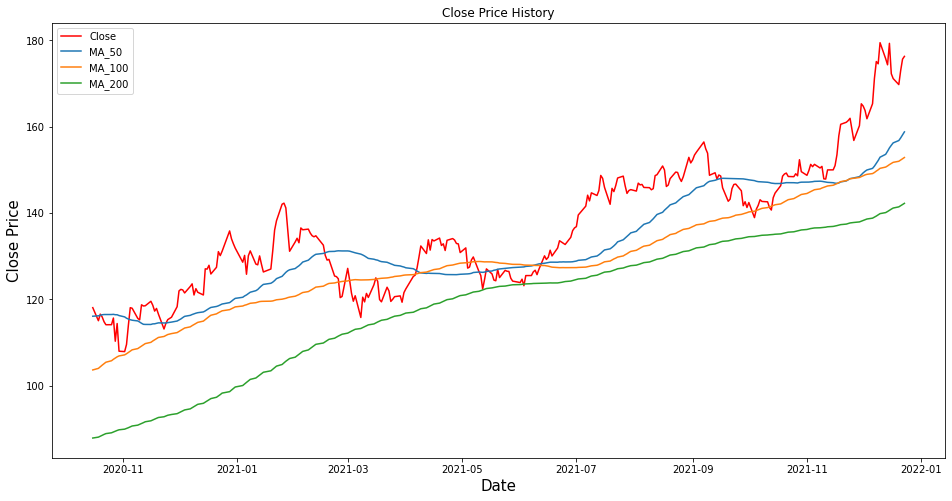

In [ ]:
#Show MA line
plt.figure(figsize=(16,8))
plt.title("Close Price History")
plt.plot(tech_idx_1['Close'][-300:] , color = "red" , label="Close" )
plt.plot(tech_idx_1['MA50'][-300:] , label="MA_50")
plt.plot(tech_idx_1['MA100'][-300:] , label="MA_100")
plt.plot(tech_idx_1['MA200'][-300:] , label="MA_200")
plt.xlabel("Date" ,fontsize=15)
plt.ylabel('Close Price' ,fontsize=15)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


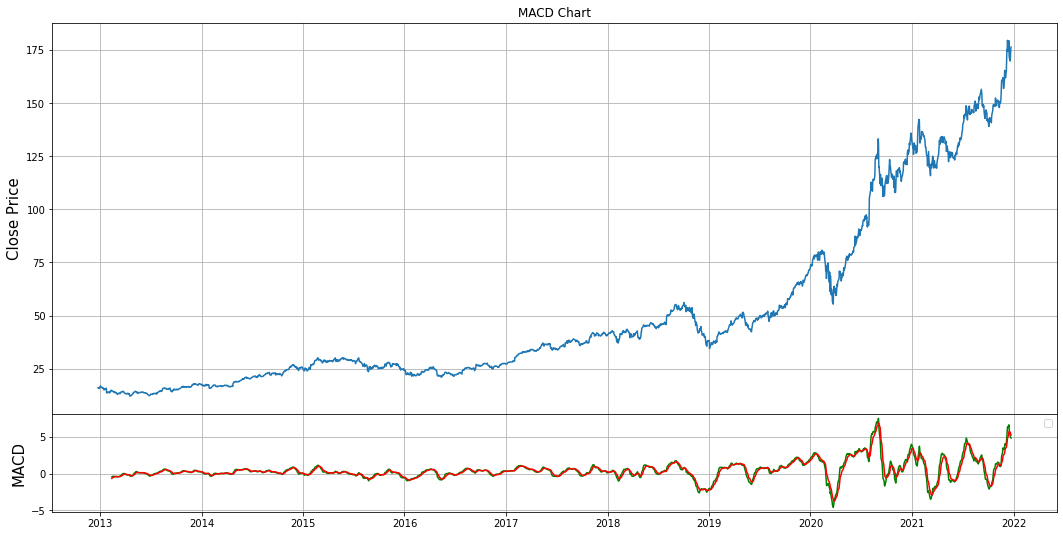

In [ ]:
def plot_macd(df , startDate, endDate):
  plt.figure(figsize=(18, 9))
  plt.title("MACD")
  ax1 = plt.subplot2grid((5,4) , (0,0) , rowspan=4 , colspan=4)
  plt.title('MACD Chart')
  plt.plot(df['Close'] , label="Close")
  plt.xlabel("Date" ,fontsize=15)
  plt.ylabel('Close Price' ,fontsize=15)
  ax1.grid(True)

  ax2 = plt.subplot2grid((5,4) , (4,0) , rowspan=1 , colspan=4 , sharex = ax1)
  plt.plot(df['MACD'] , color = 'green')
  plt.plot(df['MACDSignal'] , color = 'red')
  plt.legend()
  plt.ylabel('MACD' ,fontsize=15)
  ax2.grid(True)

  plt.subplots_adjust(hspace=0)

plot_macd(tech_idx_1 , '' , '')

<h2>Visualizing the data with RSI , William %R , Stochastic Oscillator</h2>

<h4> Stochastic Oscillator </h4>
*   A stochastic oscillator is a popular technical indicator for generating overbought and oversold signals.
*   Traditionally, readings over 80 are considered in the overbought range, and readings under 20 are considered oversold

<h4> RSI </h4>
*   The RSI provides technical traders with signals about bullish and bearish price momentum, and it is often plotted beneath the graph of an asset’s price.
*   An asset is usually considered overbought when the RSI is above 70% and oversold when it is below 30%.

<h4> William %R </h4>
*   Williams %R moves between zero and -100.
*   A reading above -20 is overbought.
*   A reading below -80 is oversold.

<h4>Note : </h4>
<p> An overbought or oversold reading doesn't mean the price will reverse. Overbought simply means the price is near the highs of its recent range, and oversold means the price is in the lower end of its recent range.
Can be used to generate trade signals when the price and the indicator move out of overbought or oversold territory. </p>







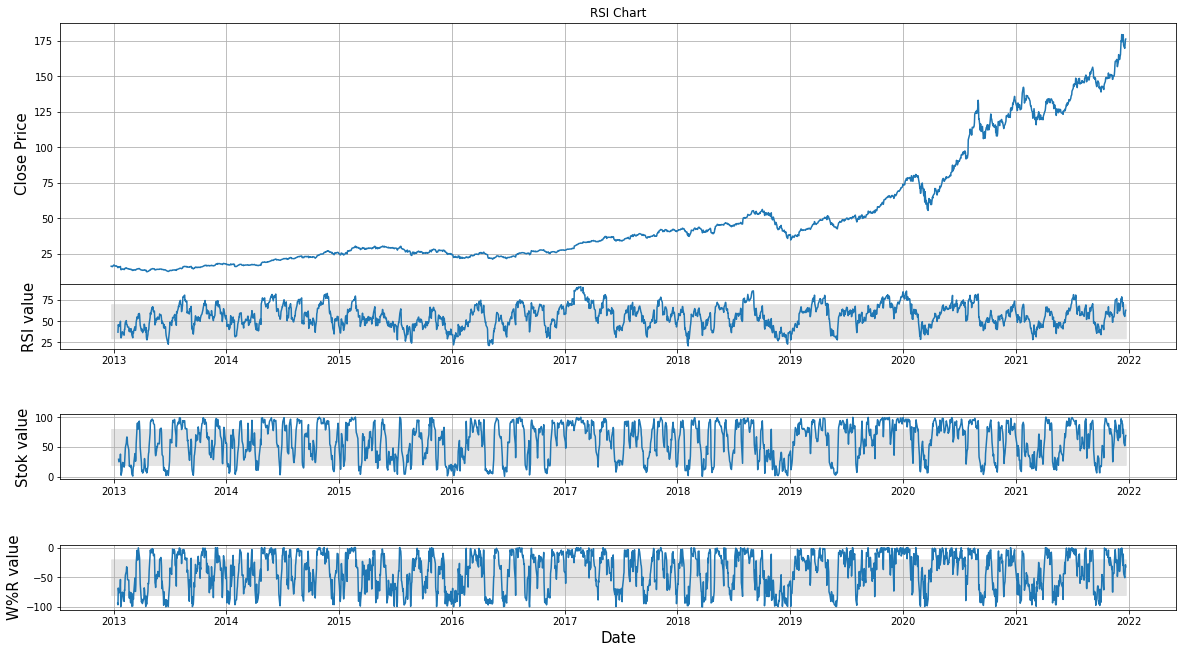

In [ ]:
def plot_rsi(df , startDate, endDate):
  plt.figure(figsize=(20, 12))
  plt.title("RSI")
  ax1 = plt.subplot2grid((10,4) , (0,0) , rowspan=4 , colspan=4)
  plt.title('RSI Chart')
  plt.plot(df['Close'] , label="Close")

  plt.xlabel("Date" ,fontsize=15)
  plt.ylabel('Close Price' ,fontsize=15)
  ax1.grid(True)

  ax2 = plt.subplot2grid((10,4) , (4,0) , rowspan=1 , colspan=4 , sharex = ax1)
  ax2.fill_between( df.index, 30 , 70 , color = "#e4e4e4")
  plt.plot(df['RSI'])
  
  plt.ylabel('RSI value' ,fontsize=15)
  ax2.grid(True)

  ax4 = plt.subplot2grid((10,4) , (6,0) , rowspan=1 , colspan=4 , sharex = ax1)
  ax4.fill_between( df.index, 20 , 80 , color = "#e4e4e4")
  plt.plot(df['Stok'])
  
  plt.ylabel('Stok value' ,fontsize=15)
  ax4.grid(True)

  ax3 = plt.subplot2grid((10,4) , (8,0) , rowspan=1 , colspan=4 , sharex = ax1)
  ax3.fill_between( df.index, -80 , -20 , color = "#e4e4e4")
  plt.plot(df['W%R14'])
  
  plt.ylabel('W%R value' ,fontsize=15)
  plt.xlabel("Date" ,fontsize=15)
  ax3.grid(True)
  
  plt.subplots_adjust(hspace=0)

plot_rsi(tech_idx_1 , '' , '')

<h3>Implementing Wiliiam %R to caculate profit</h3>

<h6>Buy Stock : if William value is higher than -80 and the previous days value is lower than -80</h6>

<h6>Sell Stock : if William value is higher than -20 and the previous days value is lower than -20</h6>

<h6>Profit is caculated by trading when the actual price moves below -80 and is above -20</h6>

In [ ]:
def implement_wr_strategy(prices, wr , isOnly):    
    buy_price = []
    sell_price = []
    wr_signal = []
    signal = 0
    profit = 0
    last_buy = -1
    last_sell = -1
    transaction = 0
    for i in range(len(wr)):
        if wr[i-1] > -80 and wr[i] < -80:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                wr_signal.append(signal)
                last_buy = prices[i]
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                wr_signal.append(0)
        elif wr[i-1] < -20 and wr[i] > -20:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                wr_signal.append(signal)
                last_sell = prices[i]
                if last_buy != -1:
                  transaction = transaction + 1
                  profit = profit + last_sell - last_buy
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                wr_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            wr_signal.append(0)

    if isOnly:
      return buy_price, sell_price, wr_signal , profit , transaction
    else:
      return profit
    
            
buy_price, sell_price, wr_signal ,profit ,transaction = implement_wr_strategy(tech_idx_1['Close'], tech_idx_1["W%R14"] , True)


In [ ]:
stock_frame_array_wr_strategy = []
for i in range(len(stock_frame_array)):
  stock_frame_array_wr_strategy.append(implement_wr_strategy(stock_frame_array[i]['Close'], stock_frame_array[i]["W%R14"] , False))

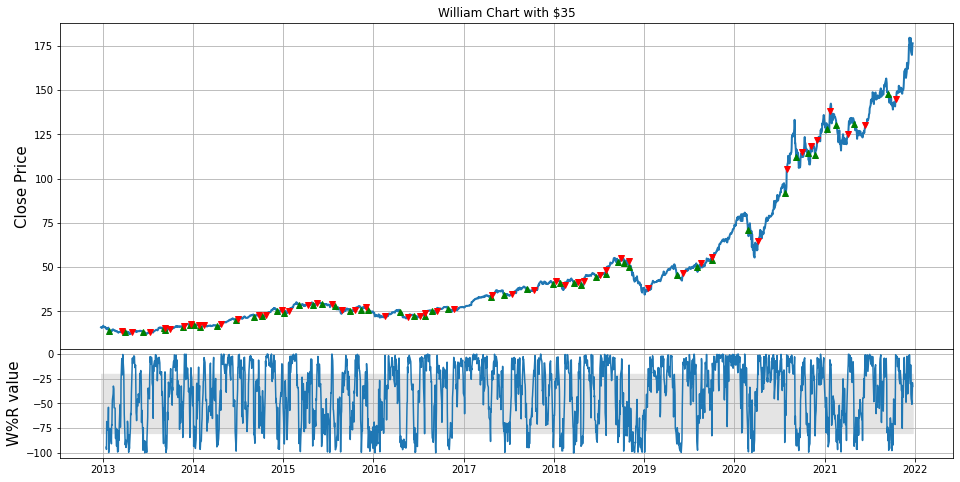

In [ ]:
def plot_wr_strategy(df , buy_price , sell_price ):
  plt.figure(figsize=(16,8))
  plt.title("Apply William R stragtegy in trading stock")

  ax1 = plt.subplot2grid((8,4) , (0,0) , rowspan=6 , colspan=4)
  plt.title(f'William Chart with ${round(profit)}')
  plt.plot(df['Close'] , label="Close" , linewidth = 2)
  ax1.plot(df.index , buy_price, marker = '^', markersize = 6, linewidth = 0, color = 'green', label = 'BUY SIGNAL')
  ax1.plot(df.index , sell_price, marker = 'v', markersize = 6, linewidth = 0, color = 'r', label = 'SELL SIGNAL')

  plt.xlabel("Date" ,fontsize=15)
  plt.ylabel('Close Price' ,fontsize=15)
  ax1.grid(True)

  ax3 = plt.subplot2grid((8,4) , (6,0) , rowspan=2 , colspan=4 , sharex = ax1)
  ax3.fill_between( df.index, -80 , -20 , color = "#e4e4e4")
  plt.plot(df['W%R14'])
  plt.ylabel('W%R value' ,fontsize=15)
  ax3.grid(True)


  plt.subplots_adjust(hspace=0)

plot_wr_strategy(tech_idx_1 , buy_price , sell_price)

<h3>Implementing RSI and MACD indicator to trade the stock</h3>

<p>We use two indicators RSI and MACD</p>

<p>MACD: **Moving average convergence divergence **: The MACD is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA.</p>

<p>The result of that calculation is the MACD line. A nine-day EMA of the MACD (called the "signal line") is then plotted on top of the MACD line, which can function as a trigger for buy and sell signals. Traders may buy the asset when the MACD crosses above its signal line and sell the asset when the MACD crosses below the signal line.</p>

<p>RSI: **Relative Strength Index** : RSI measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of an asset. The RSI is displayed as an oscillator (a line graph that moves between two extreme values) and can have a value from 0 to 100.</p>

<h4>Our Trading Strategies</h4>

<h6>Buy Stock : if RSI is higher than 80 and MACD line is below MACD Signal Line</h6>

<h6>Sell Stock : if RSI is lower than 80 and MACD line is higher MACD Signal Line</h6>

<h6>Profit is calculated by trading when the actual stock price is appropriate with the condition</h6>

In [ ]:
def implement_stoosci_strategy(prices, rsi , macd , macdsignal , isOnly):    
    buy_price = []
    sell_price = []
    sto_signal = []
    profit = 0
    last_buy = -1
    last_sell = -1
    transaction = 0
    share_number = 0
    for i in range(len(rsi)):
        if rsi[i] > 80 and macd[i] < macdsignal[i]:
            sto_signal.append(-1)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            if last_buy != -1 and share_number != 0:
                share_number = share_number - 1000
                transaction = transaction + 1
                last_sell = prices[i]
                profit = profit + last_sell - last_buy
                sell_price.pop()
                sell_price.append(prices[i])
        elif rsi[i] < 20 and macd[i] > macdsignal[i]:
            sto_signal.append(1)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            if share_number == 0:
              share_number = share_number + 1000
              last_buy = prices[i]
              buy_price.pop()
              buy_price.append(prices[i])
        else:
            sto_signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)

    if isOnly:
      return buy_price, sell_price, sto_signal , profit , transaction
    else:
      return profit
            
buy_price, sell_price, sto_signal ,profit , transaction = implement_stoosci_strategy(tech_idx_1['Close'], tech_idx_1["RSI"]
                                                                                    , tech_idx_1["MACD"] , tech_idx_1["MACDSignal"], True)
profit

0

<h3>Implementing Stochastic Oscillator with MACD to trade the stock</h3>

<h6>Buy Stock : if Slow %K is higher than Fast %D and both of it is below 20</h6>

<h6>Sell Stock : if Slow %K is lower than Fast %D and both of it is above 80</h6>

<h6>Profit is caculated by trading when the actual price moves below -80 and is above -20</h6>

In [ ]:
def implement_stoosci_strategy(prices, stod , stok , macd , macdsignal , isOnly):    
    buy_price = []
    sell_price = []
    sto_signal = []
    profit = 0
    last_buy = -1
    last_sell = -1
    transaction = 0
    share_number = 0
    for i in range(len(stod)):
        if ( stok[i] > 80 and stod[i] > 80 and stok[i] < stod[i] ) or macd[i] < macdsignal[i]:
            sto_signal.append(-1)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            if last_buy != -1 and share_number != 0:
                share_number = share_number - 1000
                transaction = transaction + 1
                last_sell = prices[i]
                profit = profit + last_sell - last_buy
                sell_price.pop()
                sell_price.append(prices[i])
        elif ( stok[i] < 20 and stod[i] < 20 and stok[i] > stod[i] ) or macd[i] > macdsignal[i]:
            sto_signal.append(1)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            if share_number == 0:
              share_number = share_number + 1000
              last_buy = prices[i]
              buy_price.pop()
              buy_price.append(prices[i])
        else:
            sto_signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)

    if isOnly:
      return buy_price, sell_price, sto_signal , profit , transaction
    else:
      return profit
            
buy_price, sell_price, sto_signal ,profit , transaction = implement_stoosci_strategy(tech_idx_1['Close'], tech_idx_1["Stod"] , tech_idx_1["Stok"] 
                                                                                    , tech_idx_1["MACD"] , tech_idx_1["MACDSignal"], True)
profit

121.57800000000012

In [ ]:
stock_frame_array_stoosci_strategy = []
for i in range(len(stock_frame_array)):
  stock_frame_array_stoosci_strategy.append(implement_stoosci_strategy(stock_frame_array[i]['Close'], stock_frame_array[i]["Stod"] , stock_frame_array[i]["Stok"] 
                                                                                    , stock_frame_array[i]["MACD"] , stock_frame_array[i]["MACDSignal"] , False))

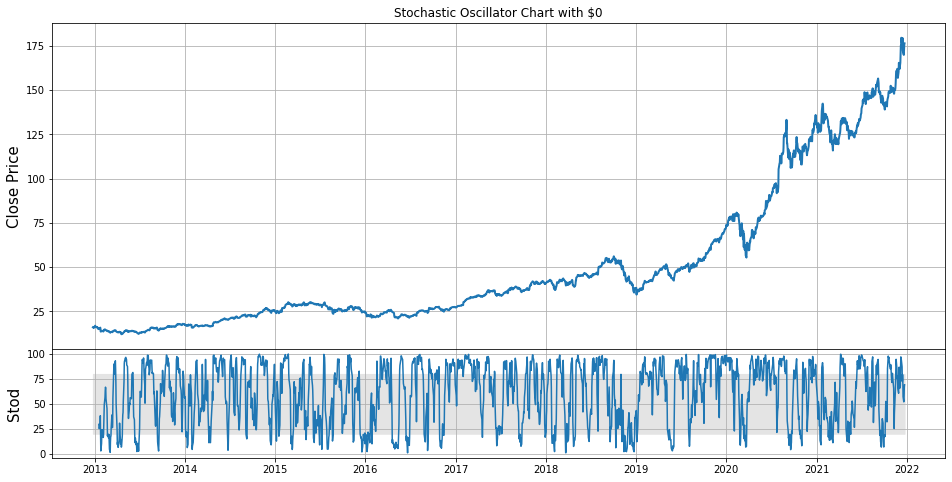

In [ ]:
def plot_stoosci_strategy(df , buy_price , sell_price ):
  plt.figure(figsize=(16,8))
  plt.title("Apply Stochastic Oscillator R stragtegy in trading stock")

  ax1 = plt.subplot2grid((8,4) , (0,0) , rowspan=6 , colspan=4)
  plt.title(f'Stochastic Oscillator Chart with ${round(profit)}')
  plt.plot(df['Close'] , label="Close" , linewidth = 2)
  ax1.plot(df.index , buy_price, marker = '^', markersize = 6, linewidth = 0, color = 'green', label = 'BUY SIGNAL')
  ax1.plot(df.index , sell_price, marker = 'v', markersize = 6, linewidth = 0, color = 'r', label = 'SELL SIGNAL')

  plt.xlabel("Date" ,fontsize=15)
  plt.ylabel('Close Price' ,fontsize=15)
  ax1.grid(True)

  ax3 = plt.subplot2grid((8,4) , (6,0) , rowspan=2 , colspan=4 , sharex = ax1)
  ax3.fill_between( df.index, 20 , 80 , color = "#e4e4e4")
  plt.plot(df['Stok'])
  plt.ylabel('Stod' ,fontsize=15)
  ax3.grid(True)


  plt.subplots_adjust(hspace=0)

plot_stoosci_strategy(tech_idx_1 , buy_price , sell_price)

<h3>Trading Algorithm Explanation</h3>
[Reference Link](https://www.investopedia.com/articles/trading/10/trend-following-countertrend.asp)

*   If the 10-day moving average is above the 30-day moving average AND the latest close is above the 200-day moving average, then we will designate the current trend as "up."
*   If the 10-day moving average is below the 30-day moving average AND the latest close is below the 200-day moving average, then we will designate the current trend as "down."

What an alert trader should be looking for is instances when:

<p>1: The 10-day moving average is above the 30-day moving average</p>
<p>2: The latest close is above the 200-day moving average</p>
<p>3: Today's oscillator is above yesterday's oscillator AND
Yesterday's oscillator value was both negative and below the oscillator value two days ago.</p>



In [ ]:
def implement_trading_strategy(prices, ma10 , ma30 , ma200 , osc):    
    buy_price = []
    sell_price = []
    trend_signal = []
    alert_signal = []
    profit = 0
    last_buy = -1
    last_sell = -1
    transaction = 0
    share_number = 0

    for i in range(0 , 200):
      trend_signal.append(0)
      buy_price.append(np.nan)
      sell_price.append(np.nan)    
      alert_signal.append((0, 0 ,np.nan))
    for i in range(200 , len(prices)):
      buy_price.append(np.nan)
      sell_price.append(np.nan)
      if ma10[i] > ma30[i] and prices[i] > ma200[i]:
        trend_signal.append(1)
        if osc[i] > osc[i-1] and osc[i-1] < 0 and osc[i-1] < osc[i-2] and share_number == 0:
          buy_price.pop()
          buy_price.append(prices[i])
          last_buy = prices[i]
          share_number = share_number + 1000
      elif ma10[i] < ma30[i] and prices[i] < ma200[i]:
        if share_number != 0:
          sell_price.pop()
          sell_price.append(prices[i])
          share_number = 0
          profit = profit + prices[i] - last_buy
          transaction = transaction + 1
        trend_signal.append(-1)
      else:
        trend_signal.append(0)
      
      if osc[i] > osc[i-1] and osc[i-1] < 0 and osc[i-1] < osc[i-2]:
        alert_signal.append((3 , 1 , prices[i]))
      elif ma10[i] > ma30[i] and ma10[i-1] <= ma30[i-1]:
        alert_signal.append((1 , 1 , prices[i]))
      elif prices[i] > ma200[i] and prices[i-1] <= ma200[i-1]:
        alert_signal.append((2 , 1 , prices[i]))
      else:
        alert_signal.append((0,0 , np.nan))

    return buy_price, sell_price, trend_signal , alert_signal , profit , transaction
            
            
buy_price, sell_price, trend_signal , alert_signal , profit , transaction = implement_trading_strategy(tech_idx_1['Close'], tech_idx_1["MA10"] , tech_idx_1["MA30"] , tech_idx_1["MA200"] , tech_idx_1["MA3"] - tech_idx_1["MA10"])
alert_signal = np.array(alert_signal)

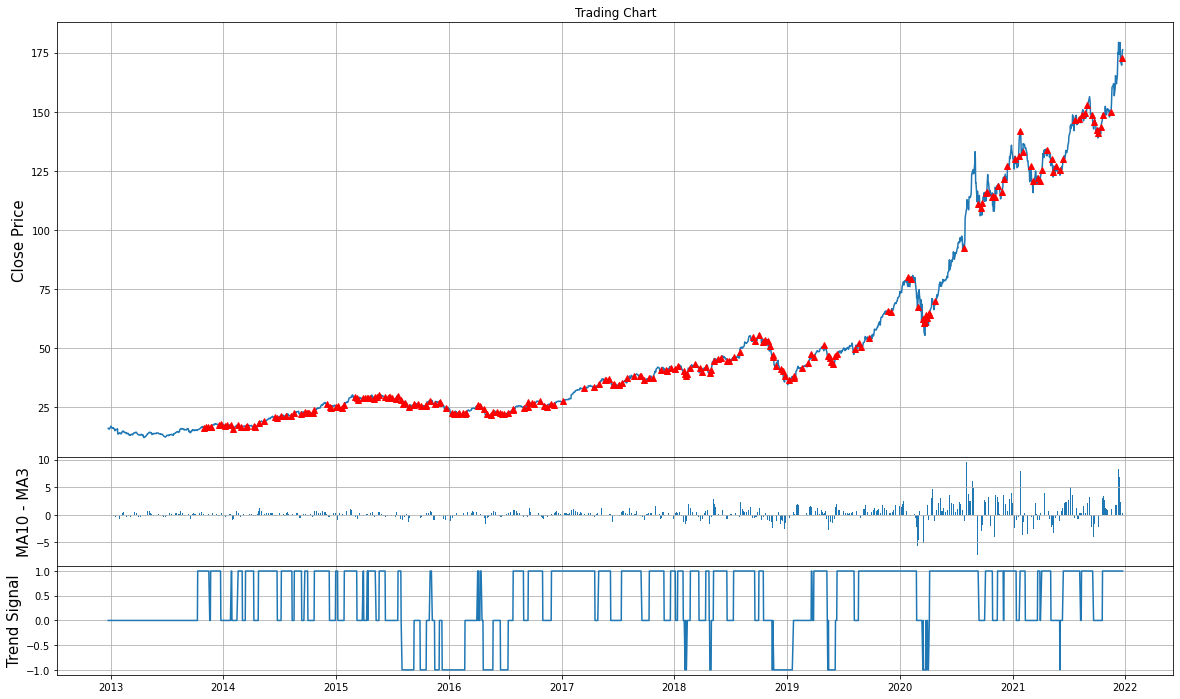

In [ ]:
def plot_trading_strat(df , startDate, endDate):
  plt.figure(figsize=(20, 12))
  plt.title("Trading chart")
  ax1 = plt.subplot2grid((6,4) , (0,0) , rowspan=4 , colspan=4)
  plt.title('Trading Chart')
  plt.plot(df['Close'] , label="Close")
  ax1.plot(df.index , alert_signal[0: , 2] , marker = '^', markersize = 6, linewidth = 0, color = 'red', label = 'BUY SIGNAL')
  plt.xlabel("Date" ,fontsize=15)
  plt.ylabel('Close Price' ,fontsize=15)
  ax1.grid(True)

  ax2 = plt.subplot2grid((6,4) , (4,0) , rowspan=1 , colspan=4 , sharex = ax1)
  plt.bar(df.index ,df['MA3'] - df['MA10'])
  plt.ylabel('MA10 - MA3' ,fontsize=15)
  ax2.grid(True)

  ax3 = plt.subplot2grid((6,4) , (5,0) , rowspan=1 , colspan=4 , sharex = ax1)
  plt.plot(df.index , trend_signal)
  plt.ylabel('Trend Signal' ,fontsize=15)
  ax3.grid(True)


  plt.subplots_adjust(hspace=0)

plot_trading_strat(tech_idx_1 , '' , '')

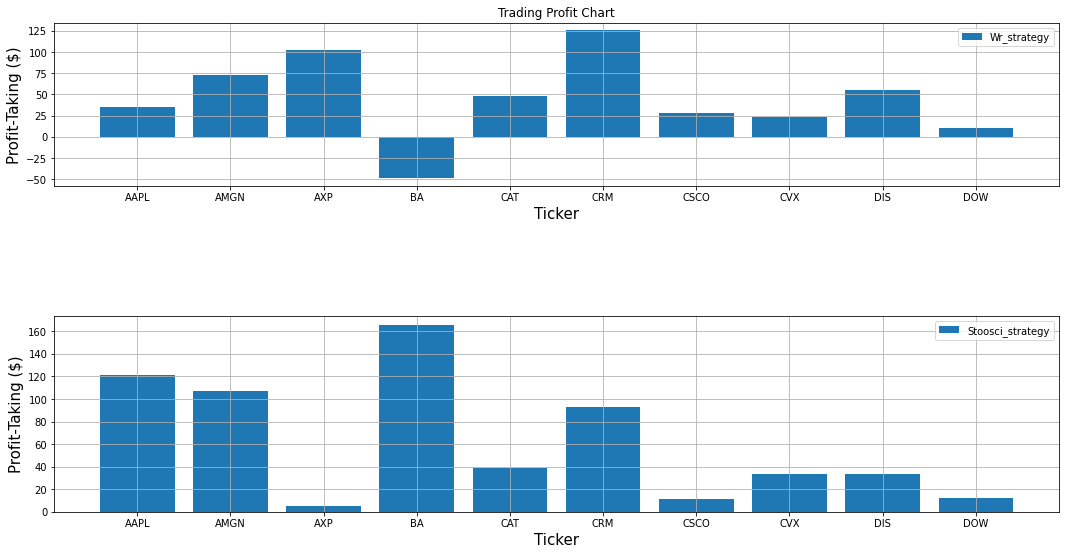

In [ ]:
def plot_trading_strategies_profit():
  plt.figure(figsize=(18, 9))
  plt.title("Profit chart")
  ax1 = plt.subplot2grid((6,4) , (0,0) , rowspan=2 , colspan=4)
  plt.title('Trading Profit Chart')
  plt.bar(stock_symbols[0:10] ,stock_frame_array_wr_strategy , label="Wr_strategy")

  plt.xlabel("Ticker" ,fontsize=15)
  plt.ylabel('Profit-Taking ($)' ,fontsize=15)
  plt.legend()
  ax1.grid(True)

  ax3 = plt.subplot2grid((5,4) , (3,0) , rowspan=2 , colspan=4 , sharex = ax1)
  plt.bar(stock_symbols[0:10] , stock_frame_array_stoosci_strategy , label="Stoosci_strategy")
  plt.ylabel('Profit-Taking ($)' ,fontsize=15)
  plt.xlabel("Ticker" ,fontsize=15)
  plt.legend()
  ax3.grid(True)


  plt.subplots_adjust(hspace=0)

plot_trading_strategies_profit()

<h2>Fourier Transformation</h2>

*   Phân tích Fourier là một kỹ thuật toán học phân tích dữ liệu chuỗi thời gian phức tạp thành các thành phần là các hàm lượng giác đơn giản hơn.
*   Ý tưởng là có thể loại bỏ nhiễu hoặc các yếu tố gây nhiễu khỏi tập dữ liệu để xác định các mẫu hoặc xu hướng thực sự.
*   Tuy nhiên nó không hữu ích trong thực tế nhiều







In [ ]:
data_fft = tech_idx_1['Close'].values
close_fft = np.fft.fft(np.asarray(data_fft))
fft_dt = pd.DataFrame({'fft' : close_fft}) 
fft_dt['absolute'] = fft_dt['fft'].apply(lambda x: np.abs(x))
fft_dt['angle'] = fft_dt['fft'].apply(lambda x: np.angle(x))


c:\users\hoang\appdata\local\programs\python\python38\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part

c:\users\hoang\appdata\local\programs\python\python38\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part

c:\users\hoang\appdata\local\programs\python\python38\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part

c:\users\hoang\appdata\local\programs\python\python38\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



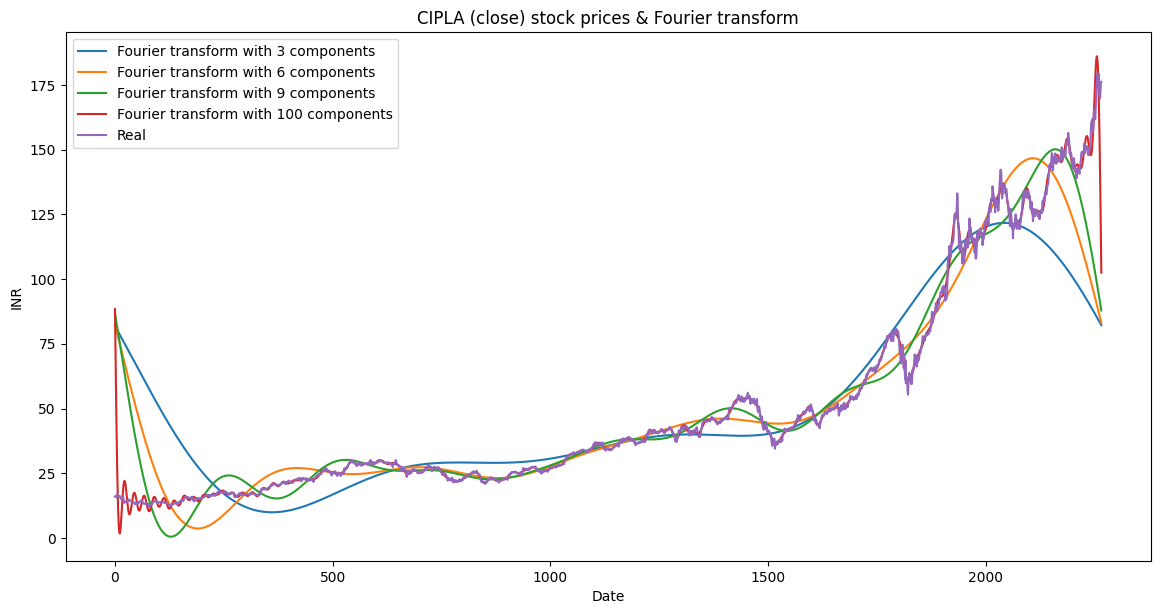

In [ ]:
plt.figure(figsize=(14,7) , dpi = 100)
fft_list = np.asarray(fft_dt['fft'])
for num_ in [3,6,9, 100]:
  fft_list_m10 = np.copy(fft_list)
  fft_list_m10[num_ : -num_] = 0
  plt.plot(np.fft.ifft(fft_list_m10) , label = "Fourier transform with {} components".format(num_))

plt.plot(data_fft , label = 'Real')

plt.xlabel('Date')
plt.ylabel('INR')
plt.title('CIPLA (close) stock prices & Fourier transform')
plt.legend()
plt.show()

In [ ]:
tech_idx_1 = tech_idx_1.fillna(0)

In [ ]:
# tech_idx_1 = tech_idx_1.fillna(0)
# tech_idx_1_values = tech_idx_1.values.astype('float32')
# tech_idx_1_values = pd.DataFrame(tech_idx_1_values)

# def ts(a , look_back  , pred_col):
#   t = a.copy()
#   t["id"] = range(1 , len(t) + 1)
#   t = t.iloc[:-look_back , :]
#   t.set_index('id' , inplace = True)
#   pre_val = a.copy()
#   pre_val = pre_val.iloc[look_back: , pred_col]
#   pre_val = pd.DataFrame(pre_val)
#   pre_val.columns = ['Pred']
#   pre_val["id"] = range(1 , len(pre_val) + 1)
#   pre_val.set_index('id' , inplace=True)
#   final_df = pd.concat([t , pre_val] ,axis= 1)
#   return final_df

# tech_idx_1_df_60 = ts(tech_idx_1_values , 60 , 3)
# tech_idx_1_df_60.fillna(0 , inplace=True)

# columns_name = []

# for i in range(len(tech_idx_1.columns) ):
#    columns_name.append("{}".format(tech_idx_1.columns[i]))

# columns_name.append("Pred(t)")
# tech_idx_1_df_60.columns = columns_name
# tech_idx_1 = tech_idx_1_df_60

In [ ]:
tech_idx_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2267 entries, 2012-12-24 to 2021-12-23
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        2267 non-null   float64
 1   High        2267 non-null   float64
 2   Low         2267 non-null   float64
 3   Close       2267 non-null   float64
 4   Volume      2267 non-null   int64  
 5   MA3         2267 non-null   float64
 6   MA10        2267 non-null   float64
 7   MA20        2267 non-null   float64
 8   MA30        2267 non-null   float64
 9   MA50        2267 non-null   float64
 10  MA100       2267 non-null   float64
 11  MA200       2267 non-null   float64
 12  ADX         2267 non-null   float64
 13  ADXR        2267 non-null   float64
 14  MACD        2267 non-null   float64
 15  MACDSignal  2267 non-null   float64
 16  RSI         2267 non-null   float64
 17  OBV         2267 non-null   float64
 18  OBV_EMA     2267 non-null   float64
 19  SMA      

<h2>* Data Pre-processing</h2>
<h5>We manipulate and drop the unnecessary column and choose the best combination of indicator among various ones after a couple of testing</h5>


*   And More specifically, we decided to feed the Simple Moving Average, Exponential MA, Bollinger Band, RSI , On Balance Volume to the model as the input and consider Close value of stock as an predicted output
*   We use MinMaxScaler to transform all the feature between 0 and 1, then split the data with 80% for trainning and 20% for testing 
*   The prediction of data will depend on the historical 60-days data  



In [ ]:
#Convert data to numpy array
dataset = tech_idx_1 #.values.astype('float32')

dataset_noclose = dataset[['SMA' , 'EMA' , 'BBANDS_U' , 'BBANDS_M' , 'BBANDS_L' , 'RSI' , 'OBV']].values
dataset_close = dataset['Close'].values.reshape(-1,1)

#Scale the dataset range in range 0-1
scalerNC = MinMaxScaler(feature_range=(0,1))
dataset_noclose_sc = scalerNC.fit_transform(dataset_noclose)

#Scale the dataset range in range 0-1
scalerC = MinMaxScaler(feature_range=(0,1))
dataset_close_sc = scalerC.fit_transform(dataset_close)

training_data_lens = math.ceil( len(dataset) * .8)

#Create the trainning dataset
#Create the scaled tranning dataset
datasetNC_train = dataset_noclose_sc[0 : training_data_lens , :]
datasetC_train = dataset_close_sc[0 : training_data_lens , :]
#Split the data 
x_train = []
y_train = []


#Train the final close value of a day based on the 60 previous day
for i in range(60, len(datasetNC_train)):
  x_train.append(datasetNC_train[i-60 : i, :])
  y_train.append(datasetC_train[i])

#Convert x_train, y_train to numpy arrays
x_train , y_train = np.array(x_train) , np.array(y_train)
#Reshape the data
# x_train = np.reshape(x_train , (x_train.shape[0] , x_train.shape[1] ,1))
#Create the testing dataset
datasetNC_test = dataset_noclose_sc[training_data_lens - 60 :, :]
datasetC_test = dataset_close_sc[training_data_lens - 60 :, :]

x_test = []
y_test = []
for i in range(60 , len(datasetNC_test)):
  x_test.append(datasetNC_test[ i- 60: i , :])
  y_test.append(datasetC_test[i])

x_test , y_test = np.array(x_test) , np.array(y_test)
#Reshape the data
# x_test = np.reshape(x_test , (x_test.shape[0] , x_test.shape[1] , 1))


In [ ]:
# one epoch = one forward pass and one backward pass of all the training examples
# batch size = the number of training examples in one forward/backward pass. 
# The higher the batch size, the more memory space you'll need.
# number of iterations = number of passes, each pass using [batch size] number of examples. 
# To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Set up early stop
early_stopping = keras.callbacks.EarlyStopping(patience=20)

In [ ]:
#Using LSTM layer with Dense  
model = Sequential()
model.add(Conv1D(
    filters = 32,
    kernel_size = 3,
    strides = 1,
    padding = 'causal',
    activation = 'relu',
    input_shape=[None, x_train.shape[2]]
))
#, input_shape = (x_train.shape[1], x_train.shape[2]
model.add(LSTM(60 , return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(60 , return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer= optimizer , loss="mean_squared_error" , metrics=["mae"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 32)          704       
                                                                 
 lstm_6 (LSTM)               (None, None, 60)          22320     
                                                                 
 dropout_12 (Dropout)        (None, None, 60)          0         
                                                                 
 lstm_7 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_13 (Dropout)        (None, 60)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 61        
                                                                 
Total params: 52,125
Trainable params: 52,125
Non-trai

In [ ]:
#Train the model
# RMSE :  5.523802992595479 #RMSE2 :  7.085317885512119 #MAPE :  12007.018004974707
# model.fit(x_train, y_train, batch_size=32, epochs= 10) #MSE :  0.8379966222497808 RMSE2 :  4.267988180711322 MAPE :  12011.957768691389
# validation_data=(x_test ,y_test)
history_lstm = model.fit(x_train, y_train, validation_data=(x_test ,y_test) , batch_size= 32 ,  epochs = 200 , callbacks=[model_checkpoint , early_stopping]) 

Epoch 1/200
55/55 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0317

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


55/55 [==============================] - 16s 217ms/step - loss: 0.0023 - mae: 0.0317 - val_loss: 0.0145 - val_mae: 0.1082
Epoch 2/200
55/55 [==============================] - ETA: 0s - loss: 4.5862e-04 - mae: 0.0156

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


55/55 [==============================] - 10s 186ms/step - loss: 4.5862e-04 - mae: 0.0156 - val_loss: 0.0087 - val_mae: 0.0820
Epoch 3/200
55/55 [==============================] - 4s 67ms/step - loss: 4.0806e-04 - mae: 0.0150 - val_loss: 0.0089 - val_mae: 0.0832
Epoch 4/200
55/55 [==============================] - ETA: 0s - loss: 3.1465e-04 - mae: 0.0130

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


55/55 [==============================] - 11s 210ms/step - loss: 3.1465e-04 - mae: 0.0130 - val_loss: 0.0034 - val_mae: 0.0490
Epoch 5/200
55/55 [==============================] - 5s 84ms/step - loss: 2.8993e-04 - mae: 0.0123 - val_loss: 0.0060 - val_mae: 0.0672
Epoch 6/200
55/55 [==============================] - 5s 85ms/step - loss: 2.9284e-04 - mae: 0.0122 - val_loss: 0.0067 - val_mae: 0.0720
Epoch 7/200
55/55 [==============================] - 5s 82ms/step - loss: 2.2408e-04 - mae: 0.0106 - val_loss: 0.0056 - val_mae: 0.0654
Epoch 8/200
55/55 [==============================] - 5s 83ms/step - loss: 2.1486e-04 - mae: 0.0102 - val_loss: 0.0038 - val_mae: 0.0521
Epoch 9/200
55/55 [==============================] - 5s 82ms/step - loss: 2.1501e-04 - mae: 0.0103 - val_loss: 0.0086 - val_mae: 0.0827
Epoch 10/200
55/55 [==============================] - 4s 82ms/step - loss: 1.9234e-04 - mae: 0.0099 - val_loss: 0.0105 - val_mae: 0.0929
Epoch 11/200
55/55 [==============================] - 5s 

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


55/55 [==============================] - 11s 198ms/step - loss: 1.6963e-04 - mae: 0.0091 - val_loss: 0.0031 - val_mae: 0.0459
Epoch 15/200
55/55 [==============================] - 5s 92ms/step - loss: 1.5600e-04 - mae: 0.0087 - val_loss: 0.0083 - val_mae: 0.0815
Epoch 16/200
55/55 [==============================] - 5s 86ms/step - loss: 1.9583e-04 - mae: 0.0098 - val_loss: 0.0108 - val_mae: 0.0948
Epoch 17/200
55/55 [==============================] - 5s 83ms/step - loss: 1.5131e-04 - mae: 0.0086 - val_loss: 0.0036 - val_mae: 0.0510
Epoch 18/200
55/55 [==============================] - 4s 81ms/step - loss: 1.3054e-04 - mae: 0.0079 - val_loss: 0.0056 - val_mae: 0.0653
Epoch 19/200
55/55 [==============================] - 4s 81ms/step - loss: 1.5023e-04 - mae: 0.0085 - val_loss: 0.0042 - val_mae: 0.0560
Epoch 20/200
55/55 [==============================] - 5s 82ms/step - loss: 1.2411e-04 - mae: 0.0078 - val_loss: 0.0057 - val_mae: 0.0666
Epoch 21/200
55/55 [==============================] 

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


55/55 [==============================] - 11s 207ms/step - loss: 1.2899e-04 - mae: 0.0080 - val_loss: 0.0028 - val_mae: 0.0437
Epoch 25/200
55/55 [==============================] - 6s 101ms/step - loss: 1.4127e-04 - mae: 0.0085 - val_loss: 0.0050 - val_mae: 0.0616
Epoch 26/200
55/55 [==============================] - ETA: 0s - loss: 1.1145e-04 - mae: 0.0074

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


55/55 [==============================] - 13s 235ms/step - loss: 1.1145e-04 - mae: 0.0074 - val_loss: 0.0018 - val_mae: 0.0339
Epoch 27/200
55/55 [==============================] - 5s 87ms/step - loss: 1.3317e-04 - mae: 0.0082 - val_loss: 0.0066 - val_mae: 0.0724
Epoch 28/200
55/55 [==============================] - 5s 83ms/step - loss: 1.1166e-04 - mae: 0.0072 - val_loss: 0.0045 - val_mae: 0.0587
Epoch 29/200
55/55 [==============================] - 5s 82ms/step - loss: 1.0663e-04 - mae: 0.0070 - val_loss: 0.0021 - val_mae: 0.0375
Epoch 30/200
55/55 [==============================] - 5s 83ms/step - loss: 1.0955e-04 - mae: 0.0074 - val_loss: 0.0046 - val_mae: 0.0595
Epoch 31/200
55/55 [==============================] - 5s 82ms/step - loss: 1.0674e-04 - mae: 0.0072 - val_loss: 0.0054 - val_mae: 0.0647
Epoch 32/200
55/55 [==============================] - 5s 84ms/step - loss: 1.1882e-04 - mae: 0.0078 - val_loss: 0.0024 - val_mae: 0.0405
Epoch 33/200
55/55 [==============================] 

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


55/55 [==============================] - 12s 217ms/step - loss: 1.0311e-04 - mae: 0.0072 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 40/200
55/55 [==============================] - 4s 81ms/step - loss: 1.1537e-04 - mae: 0.0078 - val_loss: 0.0017 - val_mae: 0.0344
Epoch 41/200
55/55 [==============================] - 4s 79ms/step - loss: 1.1918e-04 - mae: 0.0077 - val_loss: 0.0024 - val_mae: 0.0414
Epoch 42/200
55/55 [==============================] - 4s 80ms/step - loss: 9.9078e-05 - mae: 0.0069 - val_loss: 0.0017 - val_mae: 0.0335
Epoch 43/200
55/55 [==============================] - 4s 79ms/step - loss: 9.4556e-05 - mae: 0.0068 - val_loss: 0.0040 - val_mae: 0.0556
Epoch 44/200
55/55 [==============================] - 4s 81ms/step - loss: 1.0672e-04 - mae: 0.0073 - val_loss: 0.0032 - val_mae: 0.0476
Epoch 45/200
55/55 [==============================] - 4s 81ms/step - loss: 1.0859e-04 - mae: 0.0076 - val_loss: 0.0058 - val_mae: 0.0672
Epoch 46/200
55/55 [==============================] 

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


55/55 [==============================] - 11s 197ms/step - loss: 7.8921e-05 - mae: 0.0063 - val_loss: 0.0013 - val_mae: 0.0289
Epoch 58/200
55/55 [==============================] - 5s 90ms/step - loss: 8.6377e-05 - mae: 0.0064 - val_loss: 0.0026 - val_mae: 0.0436
Epoch 59/200
55/55 [==============================] - 5s 90ms/step - loss: 9.9674e-05 - mae: 0.0069 - val_loss: 0.0030 - val_mae: 0.0476
Epoch 60/200
55/55 [==============================] - 5s 90ms/step - loss: 9.0013e-05 - mae: 0.0069 - val_loss: 0.0027 - val_mae: 0.0450
Epoch 61/200
55/55 [==============================] - 5s 96ms/step - loss: 9.1285e-05 - mae: 0.0067 - val_loss: 0.0027 - val_mae: 0.0449
Epoch 62/200
55/55 [==============================] - 5s 89ms/step - loss: 1.1310e-04 - mae: 0.0077 - val_loss: 0.0054 - val_mae: 0.0667
Epoch 63/200
55/55 [==============================] - 5s 92ms/step - loss: 8.4808e-05 - mae: 0.0065 - val_loss: 0.0050 - val_mae: 0.0638
Epoch 64/200
55/55 [==============================] 

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


55/55 [==============================] - 12s 214ms/step - loss: 9.3498e-05 - mae: 0.0069 - val_loss: 6.7457e-04 - val_mae: 0.0196
Epoch 72/200
55/55 [==============================] - ETA: 0s - loss: 1.2186e-04 - mae: 0.0079

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


55/55 [==============================] - 13s 234ms/step - loss: 1.2186e-04 - mae: 0.0079 - val_loss: 6.6864e-04 - val_mae: 0.0195
Epoch 73/200
55/55 [==============================] - 5s 90ms/step - loss: 9.9630e-05 - mae: 0.0070 - val_loss: 0.0032 - val_mae: 0.0496
Epoch 74/200
55/55 [==============================] - 5s 88ms/step - loss: 7.7151e-05 - mae: 0.0063 - val_loss: 0.0021 - val_mae: 0.0391
Epoch 75/200
55/55 [==============================] - 5s 89ms/step - loss: 9.3219e-05 - mae: 0.0068 - val_loss: 0.0022 - val_mae: 0.0398
Epoch 76/200
55/55 [==============================] - 5s 93ms/step - loss: 9.9540e-05 - mae: 0.0070 - val_loss: 0.0036 - val_mae: 0.0526
Epoch 77/200
55/55 [==============================] - 5s 91ms/step - loss: 8.5627e-05 - mae: 0.0068 - val_loss: 0.0043 - val_mae: 0.0584
Epoch 78/200
55/55 [==============================] - 5s 89ms/step - loss: 8.0662e-05 - mae: 0.0066 - val_loss: 0.0022 - val_mae: 0.0399
Epoch 79/200
55/55 [============================

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


55/55 [==============================] - 11s 211ms/step - loss: 8.8509e-05 - mae: 0.0067 - val_loss: 5.4131e-04 - val_mae: 0.0176
Epoch 92/200
55/55 [==============================] - 5s 85ms/step - loss: 7.2644e-05 - mae: 0.0062 - val_loss: 0.0014 - val_mae: 0.0305
Epoch 93/200
55/55 [==============================] - 5s 85ms/step - loss: 7.8010e-05 - mae: 0.0064 - val_loss: 0.0030 - val_mae: 0.0485
Epoch 94/200
55/55 [==============================] - 5s 85ms/step - loss: 8.1991e-05 - mae: 0.0065 - val_loss: 0.0026 - val_mae: 0.0447
Epoch 95/200
55/55 [==============================] - 5s 86ms/step - loss: 8.1092e-05 - mae: 0.0064 - val_loss: 0.0036 - val_mae: 0.0529
Epoch 96/200
55/55 [==============================] - 5s 86ms/step - loss: 7.4912e-05 - mae: 0.0063 - val_loss: 5.9302e-04 - val_mae: 0.0185
Epoch 97/200
55/55 [==============================] - 5s 86ms/step - loss: 9.6649e-05 - mae: 0.0070 - val_loss: 0.0024 - val_mae: 0.0425
Epoch 98/200
55/55 [========================

In [ ]:
# plt.semilogx(history_lstm.history["lr"], history_lstm.history["loss"])
# plt.axis([1e-5, 1, 0, .1])

In [ ]:
#Using GRU  
model_gru = Sequential()
model_gru.add(GRU(60 , return_sequences=True, input_shape = (x_train.shape[1], x_train.shape[2])))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(60 , return_sequences=False))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1))

model_gru.compile(optimizer= optimizer , loss="mean_squared_error")
model_gru.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 60, 60)            12420     
                                                                 
 dropout_18 (Dropout)        (None, 60, 60)            0         
                                                                 
 gru_11 (GRU)                (None, 60)                21960     
                                                                 
 dropout_19 (Dropout)        (None, 60)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 61        
                                                                 
Total params: 34,441
Trainable params: 34,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train the model
# RMSE :  5.523802992595479 #RMSE2 :  7.085317885512119 #MAPE :  12007.018004974707
# model.fit(x_train, y_train, batch_size=32, epochs= 10) #MSE :  0.8379966222497808 RMSE2 :  4.267988180711322 MAPE :  12011.957768691389
history_gru = model_gru.fit(x_train, y_train, batch_size=32, epochs= 200 ,  validation_data=(x_test ,y_test)  , callbacks=[model_checkpoint , early_stopping] ) 

Epoch 1/200
55/55 [==============================] - 9s 87ms/step - loss: 0.0071 - val_loss: 0.0050
Epoch 2/200
55/55 [==============================] - 4s 78ms/step - loss: 5.9263e-04 - val_loss: 8.9372e-04
Epoch 3/200
55/55 [==============================] - 4s 73ms/step - loss: 4.1817e-04 - val_loss: 0.0019
Epoch 4/200
55/55 [==============================] - 4s 79ms/step - loss: 3.5725e-04 - val_loss: 0.0014
Epoch 5/200
55/55 [==============================] - 4s 76ms/step - loss: 3.7264e-04 - val_loss: 0.0013
Epoch 6/200
55/55 [==============================] - 4s 73ms/step - loss: 3.0079e-04 - val_loss: 7.8777e-04
Epoch 7/200
55/55 [==============================] - 4s 74ms/step - loss: 2.8080e-04 - val_loss: 0.0011
Epoch 8/200
55/55 [==============================] - 4s 74ms/step - loss: 2.4603e-04 - val_loss: 0.0017
Epoch 9/200
55/55 [==============================] - 4s 74ms/step - loss: 2.3176e-04 - val_loss: 8.2191e-04
Epoch 10/200
55/55 [==============================] - 4s

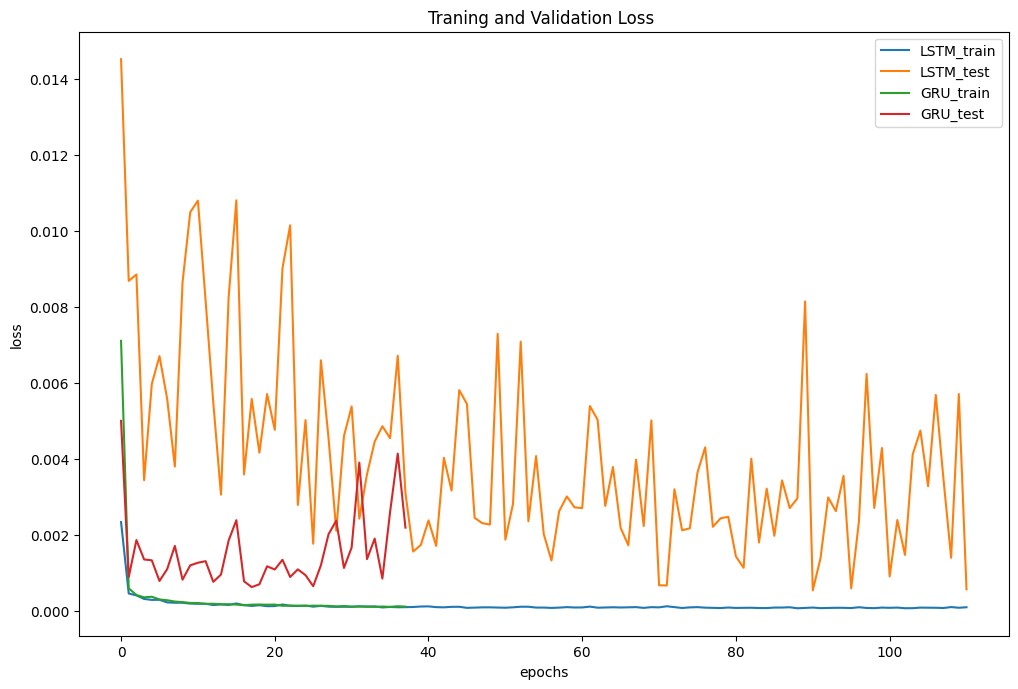

In [ ]:
plt.figure(figsize=(12,8) , dpi=100)
#history_cnn_lstm
plt.plot(history_lstm.history['loss'] , label = 'LSTM_train')
plt.plot(history_lstm.history['val_loss'] , label = 'LSTM_test')
plt.plot(history_gru.history['loss'] , label = 'GRU_train')
plt.plot(history_gru.history['val_loss'] , label = 'GRU_test')
# plt.plot(history_cnn_lstm.history['loss'] , label = 'CNNLSTM_train')
# plt.plot(history_cnn_lstm.history['val_loss'] , label = 'CNNLSTM_test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title("Traning and Validation Loss ")
plt.show()

<h4>* Root mean square value (RMSE) and Mean Absolute Percentage Error (MAPE)
  </h4>


In [ ]:
y_pred = model.predict(x_test)
#normal_scale = 1 / scaler.scale_[3]
y_pred = scalerC.inverse_transform(y_pred)
y_test1 = scalerC.inverse_transform(y_test)

mean_y_pred = y_pred.mean()
mean_y_test = y_test1.mean()

#Caculate RMSE and MAPE to indicate the absolute fit of the actual data to predicted value 
rmse = np.sqrt( np.mean(y_pred - y_test1) **2 )
print("RMSE : " , rmse)
rmse2 = np.sqrt( ((y_pred - y_test1) ** 2).mean() )
print("RMSE2 : " , rmse2)
mape = np.mean( np.abs(y_test - y_pred / y_test)) *  100
print("MAPE : " , mape)

#Caculate accuracy
accuracy = round((mean_y_pred / mean_y_test) * 100 , 2) 
print("Accuracy : " , accuracy , "%")


RMSE :  0.7242668969025945
RMSE2 :  3.9949440371342444
MAPE :  18671.030389028878
Accuracy :  99.4 %


C:\Users\hoang\AppData\Local\Temp/ipykernel_6624/3732998733.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



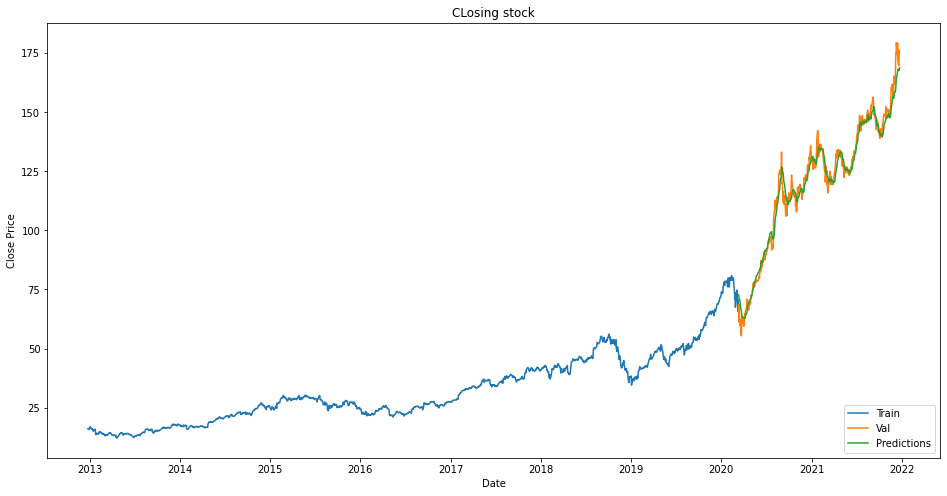

In [ ]:
data = tech_idx_1.filter(['Close'])
#Plot the data
train = data[:training_data_lens]
valid = data[training_data_lens :]
valid['Predictions'] = y_pred
#Visualize the data
plt.figure(figsize=(16,8))
plt.title("CLosing stock")
plt.xlabel("Date")
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close' ,'Predictions']])
plt.legend(['Train', 'Val' , 'Predictions'] , loc='lower right')
plt.show()

In [ ]:
model.save('LSTM_e10.h5')
model_gru.save('GRU_e10.h5')

In [ ]:
model_gru = load_model('GRU_e10.h5')
model_lstm = load_model('LSTM_e10.h5')

In [ ]:
def splitData(tech_idx_1):
  dataset = tech_idx_1
  dataset_noclose = dataset[['SMA' , 'EMA' , 'BBANDS_U' , 'BBANDS_M' , 'BBANDS_L' , 'RSI' , 'OBV']].values
  dataset_close = dataset['Close'].values.reshape(-1,1)
  scalerNC = MinMaxScaler(feature_range=(0,1))
  dataset_noclose_sc = scalerNC.fit_transform(dataset_noclose)
  scalerC = MinMaxScaler(feature_range=(0,1))
  dataset_close_sc = scalerC.fit_transform(dataset_close)
  training_data_lens = math.ceil( len(dataset) * .8)
  datasetNC_train = dataset_noclose_sc[0 : training_data_lens , :]
  datasetC_train = dataset_close_sc[0 : training_data_lens , :]
  x_train = []
  y_train = []
  for i in range(60, len(datasetNC_train)):
    x_train.append(datasetNC_train[i-60 : i, :])
    y_train.append(datasetC_train[i])
  x_train , y_train = np.array(x_train) , np.array(y_train)
  datasetNC_test = dataset_noclose_sc[training_data_lens - 60 :, :]
  datasetC_test = dataset_close_sc[training_data_lens - 60 :, :]
  x_test = []
  y_test = []
  for i in range(60 , len(datasetNC_test)):
    x_test.append(datasetNC_test[ i- 60: i , :])
    y_test.append(datasetC_test[i])
  x_test , y_test = np.array(x_test) , np.array(y_test)
  return x_test, y_test , scalerC , training_data_lens


def makePrediction(ticker , startDate , endDate , type):
  #Get the stock
  stock = ticker
  startdate = startDate 
  enddate = endDate
  ticker_df = datard.DataReader(stock, 'stooq', startdate, enddate)
  #Reverse the data frame
  ticker_df = ticker_df.iloc[::-1]
  ticker_df = technical_indicators_df(ticker_df)
  ticker_df.fillna(0)
  x_test, y_test , scaler , training_data_lens = splitData(ticker_df)

  if type == "LSTM":
    y_pred = model_lstm.predict(x_test)
  elif type == "GRU":
    y_pred = model_gru.predict(x_test)

  #Inverse Transform
  y_pred = scaler.inverse_transform(y_pred)
  y_test = scaler.inverse_transform(y_test)

  mean_y_pred = y_pred.mean()
  mean_y_test = y_test.mean()

  #Caculate RMSE and MAPE to indicate the absolute fit of the actual data to predicted value 
  rmse = np.sqrt( np.mean(y_pred - y_test) **2 )
  rmse2 = np.sqrt( ((y_pred - y_test) ** 2).mean() )
  mape = np.mean( np.abs(y_test - y_pred / y_test)) *  100
  print("MAPE : " , mape)

  #Caculate accuracy relatively
  accuracy = round((mean_y_pred / mean_y_test) * 100 , 2) 

  data = ticker_df
  train = data[:training_data_lens]
  valid = data[training_data_lens :]
  valid['Predictions'] = y_pred
  return train, valid , ticker_df , rmse , mape, accuracy
  

train , valid , df , rmse , mape, accuracy = makePrediction('AAPL' , pd.to_datetime('2012-12-24') , pd.to_datetime('2021-12-24') , 'LSTM')
#'AAPL'
#pd.to_datetime('2012-12-24') 
#pd.to_datetime('2021-12-24')

MAPE :  12017.943295947034


C:\Users\hoang\AppData\Local\Temp/ipykernel_6976/2459317513.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Get stock symbol for search pannel in dash web
df2 = pd.DataFrame( si.tickers_dow())
stock_symbols = df2.values

In [ ]:
def download_stockData(stock):
    startdate = pd.to_datetime('2012-12-24')
    enddate = pd.to_datetime('2021-12-24')
    df = datard.DataReader(stock, 'stooq', startdate, enddate)
    #Reverse the data frame
    df = df.iloc[::-1]
    return df

def get_symbol_company(symbol):
    stck = yf.Ticker(symbol)
    company_name = stck.info['longName']
    return company_name

In [ ]:
currentStock = "AAPL"
df_global = df
figure_predicted_global = {}
figure_predicted_gru_global = {}
app = dash.Dash()
server = app.server
app.config.suppress_callback_exceptions = True
app.css.config.serve_locally = True
# app.scripts.config.serve_locally = True

@app.server.route('/assests/<path:path>')
def static_file(path):
    static_folder = os.path.join(os.getcwd(), 'assests')
    return send_from_directory(static_folder, path)

# styling the sidebar
SIDEBAR_STYLE = {
    "position": "fixed",
    "top": 0,
    "left": 0,
    "bottom": 0,
    "width": "280px",
    "padding": "2rem 1rem",
    "background-color": "#f8f9fa",
}

# padding for the page content
CONTENT_STYLE = {
    "margin-left": "280px",
    "padding": "2rem 1rem",
    "flex" : "1",
}

GRAPH_STYLE_1 = {
    "padding": ".875rem 0",
    "margin-top": ".5rem",
    "border" : "1px solid #333",
}

# html.Div(id= "1" , children=[
#               dcc.Dropdown(id='LstmModel',
#                     options=[{'label': 'AAPL','value': 'AAPL'},  
#                             {'label': 'MSFT','value': 'MSFT'}], 
#                     multi=False,value='AAPL',
#                     style={"display": "block", "margin-left": "0", 
#                           "margin-right": "auto", "width": "90%"}),
#   ]),
#   html.P('Search indicator that available'),
#   html.Div(id= "2"  , children=[
#               dcc.Dropdown(id='StockIndicator',
#                 options=[{'label': 'RSI','value': 'RSI'},  
#                         {'label': 'Bolinger Band','value': 'Bolinger Band'}], 
#                 multi= True, value='',
#                 style={"display": "block", "margin-left": "0", 
#                       "margin-right": "auto", "width": "90%"}),
#   ])

user_controls_children = [
  html.H2("Dash", className="display-4"),
  html.Hr(),
  html.P(
      "Stock Prediction using ML", className="lead"
  ),
  dbc.Nav(
      [
          dbc.NavLink("Home", href="/", active="exact"),
          dbc.NavLink("Page 1", href="/page-1", active="exact"),
          dbc.NavLink("Page 2", href="/page-2", active="exact"),
      ],
      vertical=True,
      pills=True,
  ),
]

chart_mainsection_children = [
  html.H3("Stock Price Analysis Dashboard", style={"textAlign": "center" , "margin-bottom": "1rem"}),
  dcc.Tab(label= "{} Stock Data".format(currentStock),children=[
          html.Div([
              html.Div(className= 'graph-container' , children = [
                  html.H4("* Stock prediction using LSTM, CNN and GRU",style={"textAlign": "left"}),
                  dcc.Graph(
                    id="ActualData",
                    figure={
                      "data":[
                          go.Candlestick(
                              x =df.index,
                              open=df['Open'],
                              high=df['High'],
                              low=df['Low'],
                              close=df['Close']
                          )
                      ],
                      "layout":go.Layout(
                          title='Actual price',
                          xaxis={'title':'Date'},
                          
                      )
                    },
                    style=GRAPH_STYLE_1
              ),                                           
              ])
              
              html.H2(f"LSTM + CNN",style={"textAlign": "center"}),
              dcc.Graph(
                  id="PredictedData",
                  figure={
                      "data":[
                          go.Scatter(
                              x=valid.index,
                              y=valid["Predictions"],
                              mode='lines', opacity=0.7, 
                              name='AAPL Predicted'
                          ),
                          go.Scatter(
                              x=valid.index,
                              y=valid["Close"],
                              mode='lines', opacity=0.7, 
                              name='AAPL Actual'
                          )

                      ],
                      "layout":go.Layout(
                          title=f'RMSE: {rmse} , MAPE: {mape} , Accuracy: {accuracy}',
                          xaxis={'title':'Date'},
                          
                      )
                  }
              ),
              html.H2("GRU Predicted closing price",style={"textAlign": "center"}),
              dcc.Graph(
                  id="PredictedDataGRU",
                  figure={
                      "data":[
                          go.Scatter(
                              x=valid.index,
                              y=valid["Predictions"],
                              mode='lines', opacity=0.7, 
                              name='AAPL Predicted'
                          ),
                          go.Scatter(
                              x=valid.index,
                              y=valid["Close"],
                              mode='lines', opacity=0.7, 
                              name='AAPL Actual'
                          )

                      ],
                      "layout":go.Layout(
                          title='RMSE: {rmse} , MAPE: {mape} , Accuracy: {accuracy}',
                          xaxis={'title':'Date'},
                          yaxis={'title':'Closing Rate'}
                      )
                  }
              )                  
          ])                
      ])
]

children_page_main=[
    html.Div(className="row" , style={},  children=[
      html.Div(className="div-user-controls" , children=user_controls_children , style=SIDEBAR_STYLE),
      html.Div(className="columns div-for-content bg-grey" , children= chart_mainsection_children , style=CONTENT_STYLE),
      html.Div(id = "container" )
    ])
]


app.layout = html.Div([
    html.Div([
        dcc.Location(id='url'),
        html.Link(
            rel='stylesheet',
            href='/assests/css/bootstrap.css'
        ),
        # html.Link(
        #     rel='stylesheet',
        #     href='/assests/css/styles.css'
        # )
    ]),
    html.Div(id='page-content' , className="container-fluid" , children=children_page_main),

])

### Relocate the page when user navigate 
### Output : Div-for-page-content 
### Input : url when navigate 
@app.callback(
    Output("page-content", "children"),
    [Input("url", "pathname")]
)
def render_page_content(pathname):
    if pathname == "/":
        return [
                html.Div(id='page-content' , className="container-fluid" , children=children_page_main),
                ]
    elif pathname == "/page-1":
        return []
    elif pathname == "/page-2":
        return []
    # If the user tries to reach a different page, return a 404 message
    return dbc.Jumbotron(
        [
            html.H1("404: Not found", className="text-danger"),
            html.Hr(),
            html.P(f"The pathname {pathname} was not recognised..."),
        ]
    )




@app.callback([
               Output('ActualData', 'figure'),
               Output('PredictedData', 'figure'),
               Output('PredictedDataGRU', 'figure'),
              ],
              [
               Input('LstmModel', 'value'),
               Input("StockIndicator", 'value')
              ] , prevent_initial_call=True )

def multi_output(LstmModel, StockIndicator):
  global currentStock
  global df_global
  global figure_predicted_global
  figure_actual = {}
  figure_predicted = {}

  if currentStock != LstmModel:
    trace1 = []
    trace2 = []
    train , valid , df , rmse , mape, accuracy = makePrediction(LstmModel , pd.to_datetime('2012-12-24') , pd.to_datetime('2021-12-24') , 'LSTM')
    df_global = copy.deepcopy(df)
    currentStock = LstmModel
    trace1.append(go.Scatter(x= valid.index,
                y= valid["Close"],
                mode='lines', opacity=0.7, 
                name=f'Actual {LstmModel}',textposition='bottom center'))
    trace2.append(go.Scatter(x= valid.index,
                  y= valid["Predictions"],
                  mode='lines', opacity=0.6,
                  name=f'Predicted {LstmModel}',textposition='bottom center'))
    
    traces = [trace1, trace2]
    data = [val for sublist in traces for val in sublist]
    figure_predicted = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"LSTM Predicted with RMSE: {rmse} , MAPE: {mape} , Accuracy: {accuracy}",
            xaxis={"title":"Date",
                    'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
                                                        'step': 'month', 
                                                        'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M', 
                                                        'step': 'month', 
                                                        'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                    'rangeslider': {'visible': True}, 'type': 'date'},
              yaxis={"title":"Price (USD)"})}

    trace3 = []
    trace4 = []
    trace3.append(go.Candlestick(
                              x =df.index,
                              open=df['Open'],
                              high=df['High'],
                              low=df['Low'],
                              close=df['Close'],
                          ))
    traces = [trace3, trace4]
    data = [val for sublist in traces for val in sublist]
    figure_actual = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"Actual Closing price {LstmModel} Over Time",
            xaxis={"title":"Date",
                    'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
                                                        'step': 'month', 
                                                        'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M', 
                                                        'step': 'month', 
                                                        'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                    'rangeslider': {'visible': True}, 'type': 'date'},
              yaxis={"title":"Price (USD)"})}

    trace1 = []
    trace2 = []
    train , valid , df , rmse , mape, accuracy = makePrediction(LstmModel , pd.to_datetime('2012-12-24') , pd.to_datetime('2021-12-24') , 'GRU')
    currentStock = LstmModel
    trace1.append(go.Scatter(x= valid.index,
                y= valid["Close"],
                mode='lines', opacity=0.7, 
                name=f'Actual {LstmModel}',textposition='bottom center'))
    trace2.append(go.Scatter(x= valid.index,
                  y= valid["Predictions"],
                  mode='lines', opacity=0.6,
                  name=f'Predicted {LstmModel}',textposition='bottom center'))
    
    traces = [trace1, trace2]
    data = [val for sublist in traces for val in sublist]
    figure_predicted_gru = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"GRU Predicted with RMSE: {rmse} , MAPE: {mape} , Accuracy: {accuracy}",
            xaxis={"title":"Date",
                    'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
                                                        'step': 'month', 
                                                        'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M', 
                                                        'step': 'month', 
                                                        'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                    'rangeslider': {'visible': True}, 'type': 'date'},
              yaxis={"title":"Price (USD)"})}
    figure_predicted_gru_global = figure_predicted_gru

    return figure_actual, figure_predicted , figure_predicted_gru

  if currentStock == LstmModel:
    trace_actual = []
    for indicator in StockIndicator:
      if indicator == "RSI":
        trace_actual.append(go.Scatter(x= df_global.index,
              y= df_global["RSI"],
              mode='lines', opacity=0.3, 
              name=f'RSI',textposition='bottom center'))
      if indicator == "Bolinger Band":
        trace_actual.append(go.Scatter(x= df_global.index,
                y= df_global["UpperBand_BB"],
                mode='lines', opacity=0.3, 
                name=f'UpBand',textposition='bottom center'))
        trace_actual.append(go.Scatter(x= df_global.index,
                y= df_global["LowerBand_BB"],
                mode='lines', opacity=0.3, 
                name=f'LowBand',textposition='bottom center'))
        trace_actual.append(go.Scatter(x= df_global.index,
                y= df_global["MidBand_BB"],
                mode='lines', opacity=0.3, 
                name=f'MidBand',textposition='bottom center'))
      
    trace_actual.append(go.Candlestick(
                              x =df_global.index,
                              open=df_global['Open'],
                              high=df_global['High'],
                              low=df_global['Low'],
                              close=df_global['Close'],
                              name=f'Actual Value'
                          )) 
    figure_actual = {'data': trace_actual,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
                                            '#FF7400', '#FFF400', '#FF0056'],
              height=600,
              title=f"Actual Closing price {StockIndicator} Over Time",
              xaxis={"title":"Date",
                      'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
                                                          'step': 'month', 
                                                          'stepmode': 'backward'},
                                                        {'count': 6, 'label': '6M', 
                                                          'step': 'month', 
                                                          'stepmode': 'backward'},
                                                        {'step': 'all'}])},
                      'rangeslider': {'visible': True}, 'type': 'date'},
                yaxis={"title":"Price (USD)"})}
    
    return figure_actual, figure_predicted_global

@app.callback(
    Output("LstmModel", "options"),
    Input("LstmModel", "search_value"), prevent_initial_call=True
)
def update_options(search_value):
  if search_value is None:
      raise PreventUpdate
  arr = []
  count = 0
  search_value.upper()
  
  for val in stock_symbols:
    tmp = "^{}".format(search_value)
    x = re.search(tmp , val[0])
    if x:
      count = count + 1
      arr.append({"label" : val[0], "value" : val[0]})
    if count == 6:
      break 
  return arr 



###############
  
# @app.callback(Output('highlow', 'figure'),
#               [Input('my-dropdown', 'value')])

# def update_graph(selected_dropdown):
    
#     trace1 = []
#     trace2 = []
    
#     for stock in selected_dropdown:
#         df_stock = download_stockData(stock)
       
#         trace1.append(go.Scatter(x= df_stock.index,
#                      y= df_stock["High"],
#                      mode='lines', opacity=0.7, 
#                      name=f'High {stock}',textposition='bottom center'))
#         trace2.append(go.Scatter(x= df_stock.index,
#                      y= df_stock["Low"],
#                      mode='lines', opacity=0.6,
#                      name=f'Low {stock}',textposition='bottom center'))
        
#     traces = [trace1, trace2]
#     data = [val for sublist in traces for val in sublist]
#     figure = {'data': data,
#               'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
#                                             '#FF7400', '#FFF400', '#FF0056'],
#             height=600,
#             title=f"High and Low Prices for {', '.join(i for i in selected_dropdown)} Over Time",
#             xaxis={"title":"Date",
#                    'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
#                                                        'step': 'month', 
#                                                        'stepmode': 'backward'},
#                                                       {'count': 6, 'label': '6M', 
#                                                        'step': 'month', 
#                                                        'stepmode': 'backward'},
#                                                       {'step': 'all'}])},
#                    'rangeslider': {'visible': True}, 'type': 'date'},
#              yaxis={"title":"Price (USD)"})}
#     return figure

# @app.callback(
#     Output("my-dropdown2", "options"),
#     Input("my-dropdown2", "search_value"),
#     State("my-dropdown2", "value")
# )

# def update_multi_options(search_value , value):
#     if search_value is None:
#         raise PreventUpdate
#     arr = []
#     count = 0
#     search_value.upper()
    
#     for val in stock_symbols:
#       tmp = "^{}".format(search_value)
#       x = re.search(tmp , val[0])
#       if x:
#         count = count + 1
#         arr.append({"label" : val[0], "value" : val[0]})
#       if count == 6:
#         break
#     for val2 in value:
#       arr.append({"label" : val2, "value" : val2})  

#     return arr 
#     # return [{'label' : val, 'value' : get_symbol_company(val)} for val in stock_symbols if re.search("^{}".format(search_value) , val)]

# @app.callback(Output('volume', '3'),
#               [Input('my-dropdown2', 'value')])

# def update_graph(selected_dropdown_value):
#     dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
#     trace1 = []
#     for stock in selected_dropdown_value:
#         df_stock = download_stockData(stock)
#         trace1.append(go.Scatter(x= df_stock.index,
#                     y=df_stock["Volume"],
#                     mode='lines', opacity=0.7,
#                     name=f'Volume {stock}', textposition='bottom center'))
      
#     traces = [trace1]
#     data = [val for sublist in traces for val in sublist]
#     figure = {'data': data, 
#               'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
#                                             '#FF7400', '#FFF400', '#FF0056'],
#             height=600,
#             title=f"Market Volume for {', '.join(i for i in selected_dropdown_value)} Over Time",
#             xaxis={"title":"Date",
#                    'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
#                                                        'step': 'month', 
#                                                        'stepmode': 'backward'},
#                                                       {'count': 6, 'label': '6M',
#                                                        'step': 'month', 
#                                                        'stepmode': 'backward'},
#                                                       {'count': 24, 'label': '2Y',
#                                                        'step': 'month', 
#                                                        'stepmode': 'backward'},
#                                                       {'step': 'all'}])},
#                    'rangeslider': {'visible': True}, 'type': 'date'},
#              yaxis={"title":"Transactions Volume"})}
#     return figure

if __name__=='__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)


In [ ]:
print(df_global)

In [ ]:
#Apply the model
newdf = datard.DataReader("AAPL", 'stooq', startdate, enddate).filter(['Close'])
newdf = newdf.iloc[::-1]
#Get last 1 months data
last_60_days = newdf[-60:].values

#Scale the data
last_60_days_scaledData = scaler.transform(last_60_days)

X_test = [last_60_days_scaledData]
X_test = np.array(X_test)
X_test = np.reshape(X_test , (X_test.shape[0], X_test.shape[1] , 1))

#Predict 
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
#
print(pred_price)

In [ ]:
!python LSTM1_Google.py